In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
sc = SparkContext("local[*]", "logistic app")

In [3]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import math

In [4]:
class CFG : 
    D = 11
    Iteration = 20
    learning_rate = 1e-4
    monitor = 5
    K = 10

In [9]:
df_scale = pd.DataFrame(fit_df, columns = df.columns)
df_scale.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0,0.0
1,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0,1.0
2,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0,1.0
3,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0,1.0
4,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
class Logistic : 
    
    def __init__(self) : 
        self.w = []
        self.dimensions = 0
        
    def coef_(self) : 
        print(self.w)
        
    def sigmoid(self, x) : 
        return 1/(1 + np.exp(-x))
    
    def loss_func(self, w, x, t) : 
        delta = 1e-7
        z = np.dot(x, w)
        y = self.sigmoid(z)
        return -np.sum(t * np.log(y + delta) + (1 - t) * np.log((1 - y) + delta))
        
    def train(self, fit_df, iteration, learning_rate) : 
        """ Feature + Label"""
        data = sc.parallelize(fit_df)
        self.dimensions = len(fit_df[0]) - 1
        data_int = data.map(lambda x : (x[:-1], x[-1]))
        w = np.random.permutation(self.dimensions)
        wb = sc.broadcast(w)
        loss_list = []
        min_loss = 10000
        
        for i in range(iteration) : 
            gradient = data_int.map(lambda p : (p[1] - 1 / (1 + math.exp(-np.dot(wb.value, p[0])))) * p[0])\
            .reduce(lambda a, b : a + b)
            w = wb.value + learning_rate * gradient
            wb = sc.broadcast(w)
            
            loss = 0
            test_val = data_int.collect()
            for arr, lab in test_val : 
                loss += self.loss_func(wb.value, arr, lab)
            loss = loss / len(test_val)
            
            if min_loss > loss : 
                min_loss = loss
                self.w = wb.value
            
            if (i + 1) % CFG.monitor == 0 : 
                loss_list.append(loss)
                print(f"{i + 1}iter Loss : {loss}")

        print(f"Final w: \n{wb.value}, \nMin Loss : \n{min_loss}")
        return loss_list
        
    def prediction(self, df) : 
        """ Label X """
        data = sc.parallelize(df)
        wb = sc.broadcast(self.w)
        z = data.map(lambda x : np.dot(x, wb.value)).map(lambda x : 0 if x < 0.5 else 1 )
        return z.collect()

In [10]:
def k_fold_validation(df, K) : 
    len_k = int(len(df) / K)
    accs = []
    data = [element[:-1] for element in df]
    label = [element[-1] for element in df]
    
    for i in range(K) : 
        print(f"============== {i + 1}th Fold ==============")
        x_train = (df[:0 + i * len_k]).tolist() + (df[(i + 1) * len_k:]).tolist()
        x_train = np.array(x_train)
        x_test = data[0 + i * len_k : (i + 1) * len_k]
        y_test = label[0 + i * len_k : (i + 1) * len_k]
        
        lr = Logistic()
        loss = lr.train(x_train, CFG.Iteration, CFG.learning_rate)
        predict = lr.prediction(x_test)
        
        correct = 0
        for lab, pred in zip(y_test, predict) : 
            if lab == pred : 
                correct += 1
            accuracy = correct / len(x_test)
        accs.append(accuracy)
        
        #plt.plot([5 * (i+1) for i in range(len(loss))], loss)
        #plt.title(f"Loss Graph {i}")
        #plt.show()
        print(f"Accuracy for Fold {i+1} : {round(accuracy * 100, 2)}%")
    return accs

In [11]:
def main() : 
    df = pd.read_csv("cardio_train.csv", sep = ";")
    df = df.drop('id', axis = 1)
    
    scaler = MinMaxScaler()
    scaler.fit(df)
    fit_df = scaler.transform(df)
    
    acc = k_fold_validation(fit_df, CFG.K)
    plt.plot([i+1 for i in range(CFG.K)], acc)
    plt.title("Fold Accuracy")
    plt.show()
    
    print(f"Mean Accuracy for {CFG.K}Fold : {round(sum(acc)/CFG.K * 100, 2)}%")

============== 1th Fold ==============
5iter Loss : 1.2551033343232474
10iter Loss : 0.9488499298570323
15iter Loss : 0.8173838175203646
20iter Loss : 0.7454530189645889
Final w: 
[-0.34177437  0.16316464  0.79371972 -2.28825733  2.87234272  8.89929771
  1.33735092  2.31480288 -1.02191555  1.97306957 -0.11924451], 
Min Loss : 
0.7454530189645889
Accuracy for Fold 1 : 55.6%
============== 2th Fold ==============
5iter Loss : 1.3557052063829051
10iter Loss : 1.035480030958471
15iter Loss : 0.8636457819738314
20iter Loss : 0.7645554349679864
Final w: 
[ 1.53184590e+00 -2.94986870e-03 -1.34533896e+00  6.05203069e-01
  9.82819709e+00 -1.10600563e-01  1.63478509e+00  3.80167429e+00
 -3.62826198e-01  8.01185471e-01 -1.30377322e+00], 
Min Loss : 
0.7645554349679864
Accuracy for Fold 2 : 58.73%
============== 3th Fold ==============
5iter Loss : 1.4488735817961023
10iter Loss : 1.0426933664849714
15iter Loss : 0.8562631237847591
20iter Loss : 0.766575884861146
Final w: 
[ 0.39971142 -0.05409594

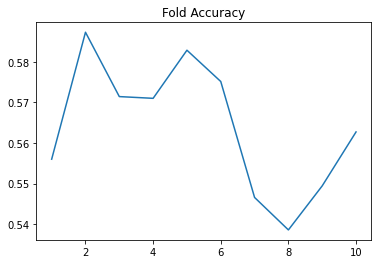

Mean Accuracy for 10Fold : 56.41%


In [12]:
main()